<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/block_total_mass_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import multiprocessing
import cupy as cp
from cupyx.scipy.special import erf

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import gc
import os
import time
from datetime import datetime


In [2]:
# @title 1 GPU simulation

# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k
        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid


        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm


        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise


        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()


        return gaussian_random_field

    def grf_64f_positive_k(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))


        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise


        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()


        return gaussian_random_field


    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf

In [3]:
# @title 1.31 GPU sampling
class GPU_SAMPLING:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf


    def max_sub_exprfs(self, lx, ly, lz, x, y, z):

        x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

        sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
        max_sub_exprf = cp.max(sub_exprf)

        del sub_exprf

        return cp.max(max_sub_exprf)

    def sub_exprfs(self, lx, ly, lz, x, y, z):

        x_min, x_max = max(x-lx,0), min(x+lx +1, self.pixel)
        y_min, y_max = max(y-ly,0), min(y+ly +1, self.pixel)
        z_min, z_max = max(z-lz,0), min(z+lz +1, self.z_pixel)

        return self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]

In [4]:
folder_path = os.getcwd()
main_path = folder_path + '/block_total_mass_data'

if not os.path.exists(main_path):
    os.makedirs(main_path)

os.chdir(main_path)

In [ ]:
k_power = 0
l= 16
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 10

num_gpu = 1 #number of GPU


num_sub_exprf = int((pixel//(2*l+1))-1)
# Total number of smaller simulation box along a given axis.

max_pixel = num_sub_exprf*(2*l+1)
# Maximum pixel that the simulation can reach. There is a margin to prevent reaching the boundary.


print("Current Working Directory:", os.getcwd())

def execute_gpu_background_mass_sampling(gpu_id):

    # Set the GPU device for this process
    cp.cuda.Device(gpu_id).use()

    rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0)

    total_mass_list = []

    num_sam = 50

    start = time.time()
    for itera in range(num_sam):

        grf = rfsim.grf_64f()
        #grf = rfsim.grf_64f_positive_k()
        exprf = rfsim.gaussian_to_exp(grf)
        del grf

        gpu_sampling = GPU_SAMPLING(exprf=exprf, pixel=pixel, z_pixel= z_pixel)

        for x in range(lx+1, max_pixel, 2*lx+1):
            for y in range(ly+1,  max_pixel, 2*ly+1):
                for z in range(lz+1, max_pixel, 2*lz+1):

                    sub_vol = gpu_sampling.sub_exprfs(lx, ly, lz, x, y, z)

                    mass = cp.sum(sub_vol)
                    if mass >= threshold:
                        total_mass_list.append( cp.asnumpy(mass) )

                    del sub_vol, mass

        if itera%10 ==0:
            #temp_list = np.array([cp.asnumpy(item) for item in total_mass_list])
            timenow = datetime.now().strftime("%d%H%M%S")
            cp.save(f'BTEMS_k_{k_power}_l_{l}_gpu{gpu_id}_{timenow}.npy', total_mass_list)
            print( f'Iter. {itera} at GPU {gpu_id}, file saved, total run time = {int(time.time() - start)}sec')
            total_mass_list = []
            gc.collect()

if __name__ == '__main__':

    # Create a multiprocessing pool for GPU
    pool = multiprocessing.Pool(processes=num_gpu)

    # Define GPU ID
    gpu_ids = range(num_gpu)
    #progress_bar = tqdm(total=Nloops, desc="Simulations", miniters = update_interval)

    # Map the simulation to GPU
    pool.map(execute_gpu_background_mass_sampling, gpu_ids)


    pool.close()
    pool.join()

Current Working Directory: /content/block_total_mass_data
Iter. 0 at GPU 0, file saved, total run time = 1sec
Iter. 10 at GPU 0, file saved, total run time = 17sec
Iter. 20 at GPU 0, file saved, total run time = 32sec


In [28]:
import glob

npy_list = glob.glob('*.npy')


print(npy_list)

['BTEMS_k_0_l_16_gpu0_19115936.npy', 'BTEMS_k_0_l_16_gpu0_19115907.npy', 'BTEMS_k_0_l_16_gpu0_19115838.npy', 'BTEMS_k_0_l_16_gpu0_19115853.npy', 'BTEMS_k_0_l_16_gpu0_19115922.npy']


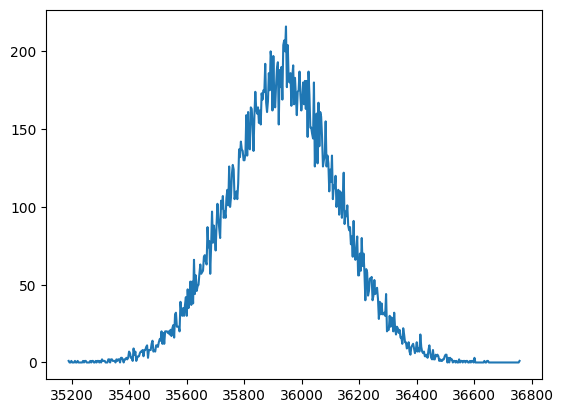

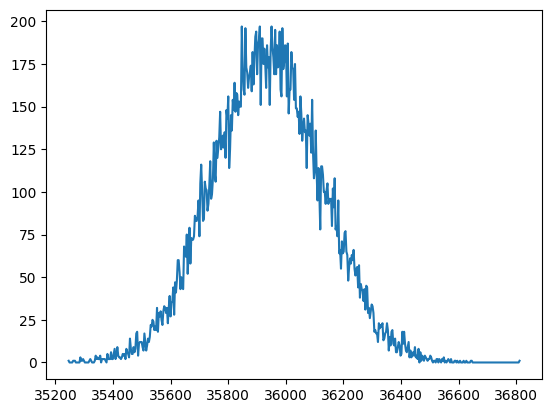

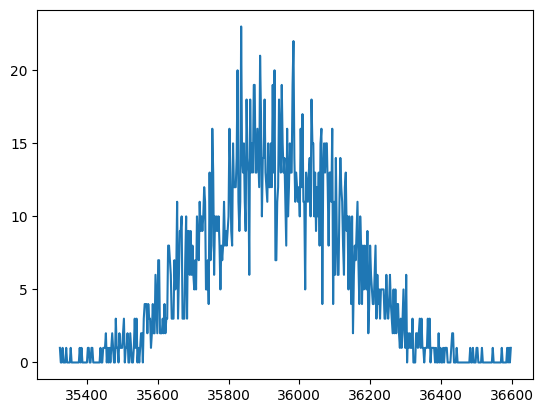

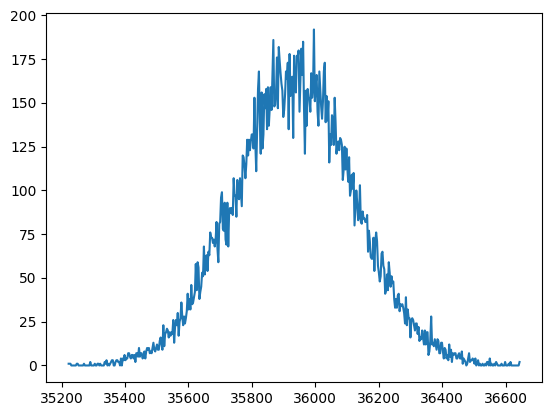

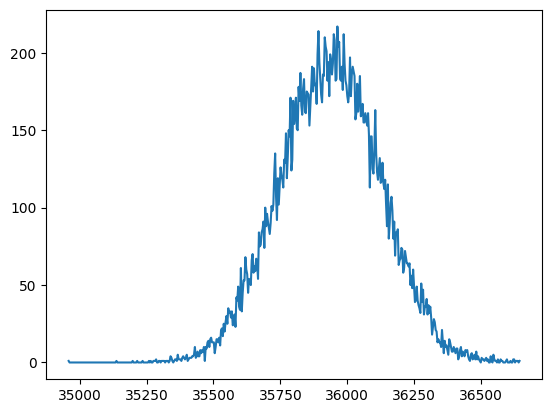

In [29]:
for npy_file in npy_list:


    data = np.load(f'{npy_file}')

    hists, bins = np.histogram(data, bins=501)

    plt.plot(bins[:-1], hists)
    plt.show()

In [30]:
full_data = []

for npy_file in npy_list:
    data = np.load(npy_file)
    print(data)
    full_data = np.concatenate([full_data,data])

[35824.39778871 36144.91478861 35763.31277752 ... 36247.60581874
 35770.32162566 35917.69731019]
[35871.14689429 35869.25993442 35740.54710042 ... 36265.49167881
 35679.11647337 36111.80436521]
[36003.79638518 35872.78727255 35801.23280217 ... 36295.00533194
 36079.22155045 35780.7655757 ]
[36156.45619919 36295.3112985  36242.50295581 ... 35869.84647519
 36036.24465725 35978.5173274 ]
[35548.24024881 35745.18752239 36108.04050404 ... 35936.47662321
 35977.67013981 36236.36564619]


In [31]:
print(data.shape, full_data.shape)

(27440,) (112504,)


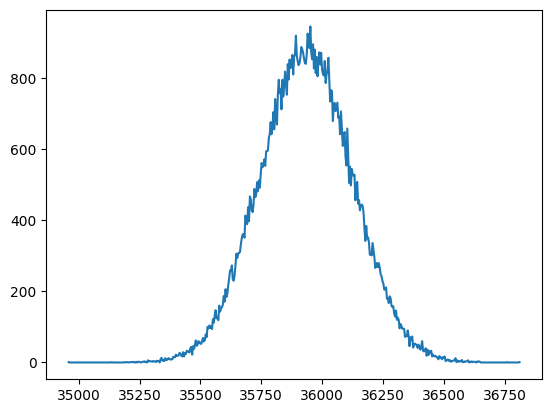

In [32]:

hists, bins = np.histogram(full_data, bins=501)

plt.plot(bins[:-1], hists)
plt.show()